In this notebook, we will explore the creation of the initial conditions for the Alaskan North Slope model. In our previous example models, the initial conditions were generated using model output fields generated as monthly averages. Here, will explore a different approach using existing model pickups.

This model poses two new challenges that were not observeded in the previous model. First, the regional model grid has different depth levels compared to the ECCO grid, so we will also need to interpolate the variables vertically. Second, the grid is at very high latitude, which means we will need to reproject the fields to an appropriate coordinate system before interpolation. 

First, import packages to visualize the model fields here:

In [1]:
# import modules for computation and plotting
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

# import pertinent tools from eccoseas
from eccoseas.ecco import pickup
from eccoseas.ecco import grid
from eccoseas.ecco import io
from eccoseas.downscale import horizontal
from eccoseas.toolbox import reprojection

## Constructing the Initial Conditions
For this model, we will use pickup files from the ECCO-Darwin model to construct the initial conditions. We will work with the physics-only pickup first, and then showcase the rest of the conditions below.

### Step 1: Download the ECCO Files
To begin, ensure that all of the necessary pickup and grid files are obtained for this configuration. These are listed on the Overview page for this model. 

These files are stored in the following directory:

In [2]:
data_folder = '../../../data/alaskan_north_slope'

print('Alaskan North Slope files:')
for file_name in sorted(os.listdir(data_folder)):
    if file_name[0]!='.':
        print(' - '+file_name)

Alaskan North Slope files:
 - AngleCS.data
 - AngleSN.data
 - DRF.data
 - NorthSlope.mitgrid
 - NorthSlope_ncgrid.nc
 - RF.data
 - hFacC.data
 - hFacS.data
 - hFacW.data
 - pickup.0000000001.data
 - pickup.0000000001.meta
 - pickup.0000000004.data
 - tile001.mitgrid
 - tile002.mitgrid
 - tile003.mitgrid
 - tile004.mitgrid
 - tile005.mitgrid


### Step 2: Read in the pickup file and the ECCO grid
To read in the pickup, we will rely on the `pickup` module from the `eccoseas.ecco`:

In [3]:
global_pickup_faces, global_pickup_metadata = \
    pickup.read_ecco_pickup_file_to_faces(os.path.join(data_folder,'pickup.0000000001'), llc=270)

The function to read the pickup file returns both the data as well as the metadata. Let's have a look at the fields in the data:

In [4]:
print('Metadata components:')
for item in global_pickup_metadata:
    print('  -', item, global_pickup_metadata[item])

Metadata components:
  - nDims 2
  - dimList [[270, 1, 270], [3510, 1, 3510]]
  - dataprec float64
  - nrecords 403
  - timeStepNumber 78841
  - timeInterval 94609200.0
  - nFlds 11
  - fldList ['Uvel', 'Vvel', 'Theta', 'Salt', 'GuNm1', 'GuNm2', 'GvNm1', 'GvNm2', 'EtaN', 'dEtaHdt', 'EtaH']


Following the previous notebooks, we will organize the data into ECCO tiles for the interpolation. As of now, the pickup file is read into ECCO faces. The `grid` module allows for an easy conversion to tiles.

In [5]:
global_pickup_tiles = {}
for field_name in global_pickup_metadata['fldList']:
    field_faces = global_pickup_faces[field_name]
    field_tiles = grid.ecco_faces_to_tiles(field_faces, llc=270, dim=3)
    global_pickup_tiles[field_name] = field_tiles

Next, we will read in the ECCO grid and convert the grid to tiles:

In [6]:
ecco_XC_faces, ecco_YC_faces, ecco_AngleCS_faces, ecco_AngleSN_faces, ecco_hFacC_faces, ecco_hFacW_faces, ecco_hFacS_faces =\
     io.read_ecco_geometry_to_faces(data_folder, llc=270, Nr=50)

In [7]:
ecco_XC_tiles = grid.ecco_faces_to_tiles(ecco_XC_faces, llc=270, dim=2)
ecco_YC_tiles = grid.ecco_faces_to_tiles(ecco_YC_faces, llc=270, dim=2)
ecco_AngleCS_tiles = grid.ecco_faces_to_tiles(ecco_AngleCS_faces, llc=270, dim=2)
ecco_AngleSN_tiles = grid.ecco_faces_to_tiles(ecco_AngleSN_faces, llc=270, dim=2)
ecco_hFacC_tiles = grid.ecco_faces_to_tiles(ecco_hFacC_faces, llc=270, dim=3)
ecco_hFacS_tiles = grid.ecco_faces_to_tiles(ecco_hFacS_faces, llc=270, dim=3)
ecco_hFacW_tiles = grid.ecco_faces_to_tiles(ecco_hFacW_faces, llc=270, dim=3)
ecco_RF = np.fromfile(os.path.join(data_folder,'RF.data'), '>f4')
ecco_DRF = np.fromfile(os.path.join(data_folder,'DRF.data'), '>f4')

In [8]:
Nr = np.size(ecco_DRF)

### Step 3: Read in the Regional Model Grid and Mask
Since the model grid has already been generated for this model (see note in Overview), we will read it in from the nc file:

In [63]:
# define the parameters that will be used in the data file
ds = nc4.Dataset('../../../data/alaskan_north_slope/NorthSlope_ncgrid.nc')
XC = ds.variables['XC'][:, :]
YC = ds.variables['YC'][:, :]
bathy = -1*ds.variables['Depth'][:,:]
AngleCS = ds.variables['AngleCS'][:,:]
AngleSN = ds.variables['AngleSN'][:,:]
hFacC = ds.variables['HFacC'][:, :, :]
hFacW = ds.variables['HFacW'][:, :, :]
hFacS = ds.variables['HFacS'][:, :, :]
delR = ds.variables['drF'][:]
ds.close()

# remove the extra row and col from hFacS and hFacW
hFacS = hFacS[:,:-1,:]
hFacW = hFacW[:,:,:-1]

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [64]:
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. For this model, we need tiles 7 and 8:

In [11]:
# define the tile list
tile_list = [7,8]

Let's verify that these tiles cover our grid:

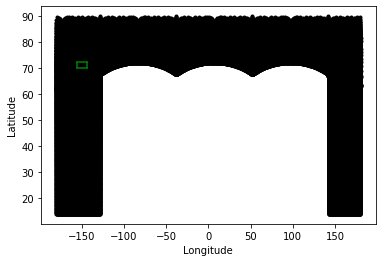

In [12]:
# plot the ECCO tile points
for tile in tile_list:
    plt.plot(ecco_XC_tiles[tile],ecco_YC_tiles[tile],'k.')

# plot the boundary of the regional model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, this model boundary (green) is completely surrounded by the points in tile 7 and 8 (black). We also note that there is extraneous information in points with longitude greater than 0 - I will omit these points as well. Given these observations, now I read in points from just those tiles to use in interpolation:

In [13]:
# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_AngleCS_points = np.zeros((total_points, ))
ecco_AngleSN_points = np.zeros((total_points, ))
ecco_maskC_points = np.zeros((Nr, total_points))
ecco_maskW_points = np.zeros((Nr, total_points))
ecco_maskS_points = np.zeros((Nr, total_points))
ecco_hFacW_points = np.zeros((Nr, total_points))
ecco_hFacS_points = np.zeros((Nr, total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()

    ecco_AngleCS_points[points_counted:points_counted+tile_N] = ecco_AngleCS_tiles[tile_number].ravel()
    ecco_AngleSN_points[points_counted:points_counted+tile_N] = ecco_AngleSN_tiles[tile_number].ravel()
    
    for k in range(Nr):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        if tile_number<7:
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        else:
            level_hFacS = ecco_hFacW_tiles[tile_number][k, :, :] # these are switched due to the 
            level_hFacW = ecco_hFacS_tiles[tile_number][k, :, :] # assumptions about velocity - see note below
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        level_maskC = np.copy(level_hFacC)
        level_maskC[level_maskC>0] = 1
        level_maskW = np.copy(level_hFacW)
        level_maskW[level_maskW>0] = 1
        level_maskS = np.copy(level_hFacS)
        level_maskS[level_maskS>0] = 1
        ecco_maskC_points[k, points_counted:points_counted+tile_N] = level_maskC.ravel()
        ecco_maskW_points[k, points_counted:points_counted+tile_N] = level_maskW.ravel()
        ecco_maskS_points[k, points_counted:points_counted+tile_N] = level_maskS.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = (ecco_XC_points<-140) & (ecco_XC_points>-160) & (ecco_YC_points>65) & (ecco_YC_points<80)
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

We can double check we have selected the right points by recreating the same plot above:

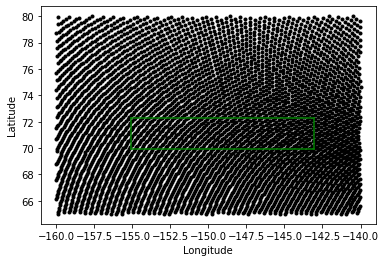

In [14]:
# plot the ECCO tile points
plt.plot(ecco_XC_points,ecco_YC_points,'k.')

# plot the boundary of the regional model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Step 5: Interpolate the ECCO fields vertically

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [15]:
# make a file dictionary to loop over
variable_names = global_pickup_metadata['fldList']

Now, read the initial condition fields from the same tiles. Here, we have to confront the weirdness of the ECCO LLC grid

In [16]:
# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if variable_name in ['Uvel','Vvel']:
        u_grid_tiles = global_pickup_tiles['Uvel']
        v_grid_tiles = global_pickup_tiles['Vvel']
        grid_tiles = u_grid_tiles # hack for testing, fix later
    else:
        grid_tiles = global_pickup_tiles[variable_name]

    # create a grid of zeros to fill in
    N = np.shape(grid_tiles[1])[-1]*np.shape(grid_tiles[1])[-2]
    if variable_name in ['EtaN', 'dEtaHdt', 'EtaH']:
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((Nr, N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name in ['EtaN', 'dEtaHdt', 'EtaH']:
            init_grid[0,points_counted:points_counted+N] = \
                 grid_tiles[tile_number][0, :, :].ravel()
        else:
            for k in range(Nr):
                init_grid[k,points_counted:points_counted+N] = \
                     grid_tiles[tile_number][k, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    init_grid = init_grid[:,local_indices]

    # apply some corrections
    if variable_name == 'Uvel':
        for k in range(Nr):
            non_zero_indices = ecco_hFacW_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'Vvel':
        for k in range(Nr):
            non_zero_indices = ecco_hFacS_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
    
    init_grids.append(init_grid)

### Step 5: Interpolate the Fields onto the Model Grid
Next, we will interpolate the ECCO pickup fields onto the regional model domain. We will use the `horizontal` module from the `eccoseas` package to accomplish this interpolation. However, we have to be a little bit careful in this region of the world near the pole since the longitude and latitude mesh is quite distorted in terms of absolute distance. 

First, let's try this in latitude-longitude coordinates:

In [17]:
interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                       init_grid, ecco_maskC_points, 
                                                       XC, YC, maskC, testing=True, printing=True, use_legacy=True, verbose=True)


# output the interpolated grid
#output_file = os.path.join(input_dir,'ics',variable_name+'_IC.bin')
#interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    Working on level 0 of 1 (338562 nonzero points found)


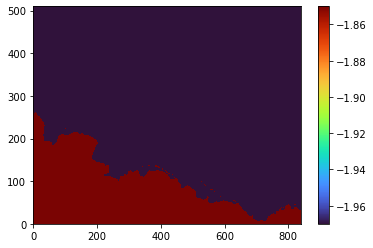

In [18]:
C = plt.pcolormesh(interpolated_grid[0,:,:],vmin=-1.97, vmax=-1.85, cmap='turbo')
plt.colorbar(C)
plt.show()

### Step 5 (Revised for the Arctic): Interpolate the Fields onto the Model Grid 

Next, let's try reprojecting coordinates to that distances are computed more appropriately for the location. We can do this with the `reprojection` model provided with **eccoseas**:

In [19]:
utm_zone_epsg = 32606
utm_coordinates = reprojection.reproject_polygon(np.column_stack([ecco_XC_points, ecco_YC_points]), 4326, utm_zone_epsg)

regional_coordinates = reprojection.reproject_polygon(np.column_stack([XC.ravel(), YC.ravel()]), 4326, utm_zone_epsg)
X = regional_coordinates[:,0].reshape(np.shape(XC))
Y = regional_coordinates[:,1].reshape(np.shape(XC))

In [20]:
ecco_maskC_on_regional_domain = np.zeros_like(maskC)
for k in range(1):
    ecco_maskC_on_regional_domain[k,:,:] = griddata(utm_coordinates, ecco_maskC_points[0,:], (X, Y), method='nearest')

In [21]:
ecco_maskC_on_regional_domain = np.ones_like(maskC)
threshold = 25e3 # approximate ECCO resolution in this region
for k in range(1):
    level = np.ones_like(ecco_maskC_on_regional_domain[k,:,:])
    for p in range(np.shape(utm_coordinates)[0]):
        if ecco_maskC_points[k,p]==0:
            dist = ((utm_coordinates[p,0]-X)**2 + (utm_coordinates[p,1]-Y)**2)**0.5
            level[dist<threshold] = 0
            ecco_maskC_on_regional_domain[k,:,:] =level

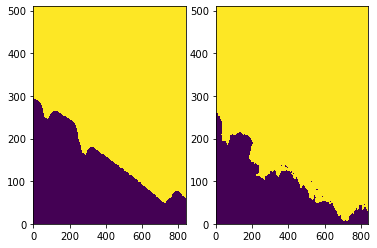

In [22]:
plt.subplot(1,2,1)
plt.pcolormesh(ecco_maskC_on_regional_domain[0,:,:])
plt.subplot(1,2,2)
plt.pcolormesh(maskC[0,:,:])

In [23]:
interpolated_grid = horizontal.downscale_3D_points(utm_coordinates,
                                                   init_grid, ecco_maskC_points, 
                                                   X, Y, maskC, ecco_maskC_on_regional_domain,
                                                   testing=True, printing=True)

    Working on level 0 of 1 (338562 nonzero points found)


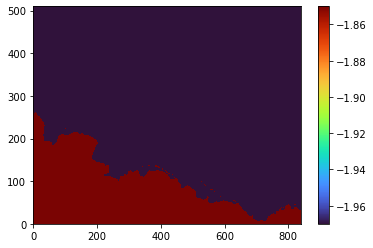

In [24]:
C = plt.pcolormesh(interpolated_grid[0,:,:],vmin=-1.97, vmax=-1.85, cmap='turbo')
plt.colorbar(C)
plt.show()

In [ ]:
pickup_grids = []

# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):

    print('    - Interpolating the '+variable_name+' grid')

    # read in the correct mask for each variable
    if variable_name.lower() in ['etan','detahdt','etah']:
        regional_mask = maskC[:1,:,:]
        ecco_mask = ecco_maskC_points[:1,:]
    elif variable_name.lower() == 'uvel':
        regional_mask = maskW
        ecco_mask = ecco_maskW_points
    elif variable_name.lower() == 'vvel':
        regional_mask = maskS
        ecco_mask = ecco_maskS_points
    else:
        regional_mask = maskC
        ecco_mask = ecco_maskC_points

    interpolated_grid = horizontal.downscale_3D_points(utm_coordinates,
                                                       init_grid, ecco_mask, 
                                                       X, Y, regional_mask, ecco_maskC_on_regional_domain,
                                                       testing=True)
    #interpolated_grid = np.zeros_like(regional_mask)
    

    pickup_grids.append(interpolated_grid)

    - Interpolating the Uvel grid
    - Interpolating the Vvel grid
    - Interpolating the Theta grid
    - Interpolating the Salt grid
    - Interpolating the GuNm1 grid
    - Interpolating the GuNm2 grid
    - Interpolating the GvNm1 grid
    - Interpolating the GvNm2 grid


In [62]:
input_dir = data_folder

In [46]:
metadata = global_pickup_metadata
#make some changes as needed
Nr = 81
metadata['nrecords'] = 8*Nr+3
print(Nr)

pickup_grid = np.zeros((8*Nr+3, np.shape(XC)[0], np.shape(XC)[1]))
counter = 0
for i in range(len(pickup_grids)):
    print('       - Stacking field for '+variable_names[i])
    pickup_grid[counter:counter+np.shape(var_grid)[0],:,:] = var_grid
    counter+=np.shape(var_grid)[0]

output_file_path = os.path.join(input_dir,'pickup.0000000004')
pickup.write_mitgcm_pickup_file(output_file_path, pickup_grid, metadata)

81
       - Stacking field for Uvel
       - Stacking field for Vvel
       - Stacking field for Theta
       - Stacking field for Salt
       - Stacking field for GuNm1
       - Stacking field for GuNm2
       - Stacking field for GvNm1
       - Stacking field for GvNm2
       - Stacking field for EtaN
       - Stacking field for dEtaHdt
       - Stacking field for EtaH


### Step 6: Plotting the Initial Condition Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [47]:
# 'Uvel', 'Vvel', 'Theta', 'Salt', 'GuNm1', 'GuNm2', 'GvNm1', 'GvNm2', 'EtaN', 'dEtaHdt', 'EtaH'
meta_dict = {'EtaN':[0.1, 0.5, 'viridis', 'm'],
             'dEtaHdt':[0.1, 0.5, 'viridis', 'm'],
             'EtaH':[0.1, 0.5, 'viridis', 'm'],
            'Theta':[6, 18, 'turbo', 'm'],
            'Salt':[32, 35, 'viridis', 'm'],
            'Uvel':[-0.25, 0.25, 'seismic', 'm/s'],
            'Vvel':[-0.25, 0.25, 'seismic', 'm/s'],
            'GuNm1':[-0.25, 0.25, 'seismic', 'm/s$^2$'],
            'GvNm1':[-0.25, 0.25, 'seismic', 'm/s$^2$'],
            'GuNm2':[-0.25, 0.25, 'seismic', 'm/s$^2$'],
            'GvNm2':[-0.25, 0.25, 'seismic', 'm/s$^2$']}

In [55]:
pickup_file_path = os.path.join(input_dir,'pickup.0000000004')
pickup_grids, pickup_metadata = pickup.read_ecco_pickup_file_to_compact(pickup_file_path, Nr=50)

In [56]:
pickup_metadata

{'nDims': 2,
 'dimList': [[840, 1, 840], [510, 1, 510]],
 'dataprec': 'float64',
 'nrecords': 651,
 'timeStepNumber': 78841,
 'timeInterval': 94609200.0,
 'nFlds': 11,
 'fldList': ['Uvel',
  'Vvel',
  'Theta',
  'Salt',
  'GuNm1',
  'GuNm2',
  'GvNm1',
  'GvNm2',
  'EtaN',
  'dEtaHdt',
  'EtaH']}

Then, I'll create all of the subplots:

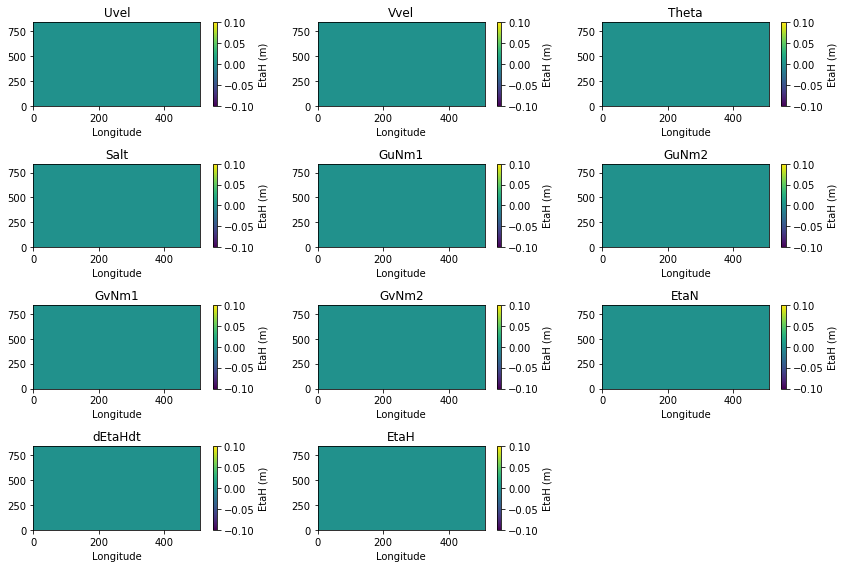

In [60]:
fig = plt.figure(figsize=(12,8))

plot_counter = 1
for variable_name in pickup_metadata['fldList']:
    init_grid = pickup_grids[variable_name]
    
    plt.subplot(4,3,plot_counter)
    C = plt.pcolormesh(init_grid[0,:,:], # just the surface for plotting
                       #vmin=meta_dict[variable_names[i]][0],
                       #vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')
    plt.title(variable_name)

    plot_counter+=1

plt.tight_layout()

plt.show()

So far so good! Now we need to make our the rest of our initial conditions.